<a href="https://colab.research.google.com/github/rosipapa/colab/blob/main/detect_skin_lesion_flw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset

In [ ]:
# Upload json with access key to kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rosipapa","key":"9ffd59b4c9238aed2c5d4ee0e33d9231"}'}

In [ ]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 12.2 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72829 sha256=2a5b46de116e629851c6572c58e54338d560f35c74e8302a7a1de2fbbfe37d67
  Stored in directory: /root/.cache/pip/wheels/5e/41/71/6379e2c66d1a7c539e3e60f0378d64ecb2a24e617d8292fafa
Successfully built kaggle
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# create a directory to save files
! mkdir dataset

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [04:34<00:00, 23.5MB/s]
100% 5.20G/5.20G [04:34<00:00, 20.3MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip -d ham10000_dataset/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_dataset/ham10000_images_part_2/ISIC_0029337.jpg  
  inf

In [ ]:
# Check files
!ls ham10000_dataset/

ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


# Install Flower

In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib

# Load images

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cpu
Flower 1.11.1 / PyTorch 2.4.1+cu121


In [ ]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
import torchvision.transforms as transforms
import torch


NUM_CLASSES = 7
BATCH_SIZE = 32

# Dataset class for Skin Cancer MNIST: HAM10000
class SkinCancerDataset(Dataset):
    def __init__(self, image_dir_1, image_dir_2, metadata_file, transform=None):
        self.image_dir_1 = image_dir_1
        self.image_dir_2 = image_dir_2
        self.metadata = pd.read_csv(metadata_file)
        self.metadata['dx'] = self.metadata['dx'].astype('category')  # Converte 'dx' to class
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_id = self.metadata.iloc[idx]['image_id']
        label = self.metadata.iloc[idx]['dx']
        # Load the image
        img_path_1 = os.path.join(self.image_dir_1, f"{img_id}.jpg")
        img_path_2 = os.path.join(self.image_dir_2, f"{img_id}.jpg")

        if os.path.exists(img_path_1):
            img_path = img_path_1
        elif os.path.exists(img_path_2):
            img_path = img_path_2
        else:
            raise FileNotFoundError(f"Image {img_id}.jpg not found in both directories")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Map label to class index
        label_idx = self.metadata['dx'].cat.codes[idx]
        return image, label_idx

def load_datasets(partition_id: int):
    # Define transforms
    pytorch_transforms = transforms.Compose(
        [
            transforms.Resize((64, 64)),  # Image size
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

    # Load dataset
    dataset = SkinCancerDataset(
        image_dir_1='/content/ham10000_dataset/HAM10000_images_part_1',
        image_dir_2='/content/ham10000_dataset/HAM10000_images_part_2',
        metadata_file='/content/ham10000_dataset/HAM10000_metadata.csv',
        transform=pytorch_transforms
    )

    # Split train, validation and test (80% train, 10% validation, 10% test)
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    print(f"Número de imagens no treinamento: {len(train_dataset)}")
    print(f"Número de imagens no test: {len(test_dataset)}")
    print(f"Número de imagens na validação: {len(val_dataset)}")

    return trainloader, valloader, testloader


Número de imagens no treinamento: 8012
Número de imagens no test: 1002
Número de imagens na validação: 1001


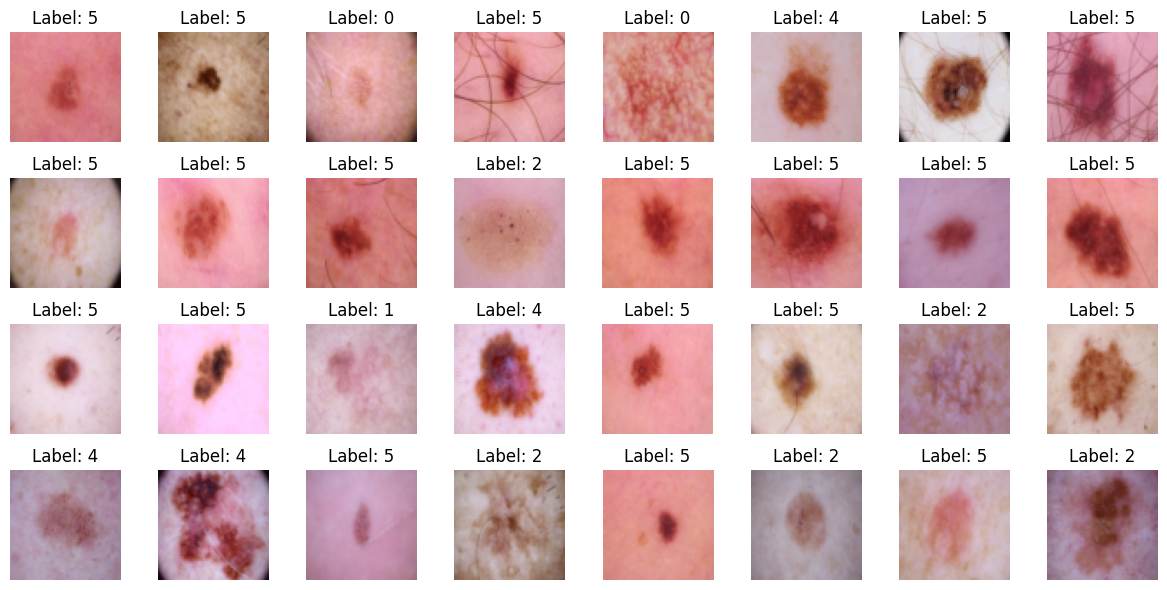

In [ ]:
import matplotlib.pyplot as plt

# Load train DataLoader
trainloader, _, _ = load_datasets(partition_id=0)

# Get images and labels
batch = next(iter(trainloader))
images, labels = batch

# Reshape and convert array NumPy
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and subplot grid
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Images loop to plot
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")

# Show images
fig.tight_layout()
plt.show()


# Model

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)  # adjust according to image dimensions 64x64
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)  # Adjusted for 7 classes

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
import torch

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0

        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            labels = labels.long()

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader)
        epoch_acc = correct / total

        if verbose:
            print(f"Epoch {epoch + 1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            labels = labels.long()

            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy


# Load dataloaders
trainloader, valloader, testloader = load_datasets(partition_id=0)

# Start device
net = Net().to(DEVICE)


epochs_to_train = 10

for epoch in range(epochs_to_train):
    train(net, trainloader, 1, verbose=False)  # 1 epoch by iteration
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch + 1}: validation loss {loss:.4f}, accuracy {accuracy:.4f}")

# Final test
loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss:.4f}\n\taccuracy {accuracy:.4f}")



Número de imagens no treinamento: 8012
Número de imagens no test: 1002
Número de imagens na validação: 1001
Epoch 1: validation loss 0.8788, accuracy 0.7093
Epoch 2: validation loss 0.8264, accuracy 0.7073
Epoch 3: validation loss 0.7733, accuracy 0.7273
Epoch 4: validation loss 0.7597, accuracy 0.7473
Epoch 5: validation loss 0.7271, accuracy 0.7532
Epoch 6: validation loss 0.7510, accuracy 0.7592
Epoch 7: validation loss 0.7022, accuracy 0.7692
Epoch 8: validation loss 0.7105, accuracy 0.7502
Epoch 9: validation loss 0.7175, accuracy 0.7692
Epoch 10: validation loss 0.7082, accuracy 0.7572
Final test set performance:
	loss 0.7381
	accuracy 0.7315


# Flower

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


In [ ]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [ ]:
#import multiprocessing
#multiprocessing.set_start_method('spawn')


In [ ]:
import nest_asyncio
nest_asyncio.apply()

NUM_CLIENTS = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour."""

    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)

# Execute the simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=11609) 2024-10-06 12:33:15.376464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11609) 2024-10-06 12:33:15.412136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11609) 2024-10-06 12:33:15.422590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=11609) 2024-10-06 12:33:17.147476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinam

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinam

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinam

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinam

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinam

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001
(ClientAppActor pid=11609) Número de imagens no treinamento: 8012
(ClientAppActor pid=11609) Número de imagens no test: 1002
(ClientAppActor pid=11609) Número de imagens na validação: 1001


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 3829.24s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.8923945803195238
INFO :      		round 2: 0.7842091355472803
INFO :      		round 3: 0.7402251661755145
INFO :      		round 4: 0.6862538574263454
INFO :      		round 5: 0.6501995211467146
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.6759240759240759),
INFO :      	              (2, 0.7044955044955046),
INFO :      	              (3, 0.721078921078921),
INFO :      	              (4, 0.7546453546453546),
INFO :      	              (5, 0.7646353646353646)]}
INFO :      
